In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

Для улучшения точности сети LeNet при классификации MNIST и достижения показателя точности в 0.95, можно применить несколько модификаций:

1. Заменим `Tanh` на `ReLU`, чтобы повысить скорость и стабильность обучения.
2. Dropout помогает предотвратить переобучение. Добавим слой Dropout.
3. Использование оптимизатора `Adam` вместо `SGD` может улучшить производительность (наверное...).
4. **Увеличение количества фильтров в сверточных слоях**: добавление большего числа фильтров может улучшить способность модели распознавать сложные паттерны.

In [2]:
# Гиперпараметры
BATCH_SIZE = 256
lr = 0.001
num_epochs = 15

In [3]:
# Загрузка и предобработка данных
transforms = tv.transforms.Compose([
    tv.transforms.Resize(32),
    tv.transforms.ToTensor()
])

In [4]:
train_dataset = tv.datasets.MNIST('.', train=True, transform=transforms, download=True)
test_dataset = tv.datasets.MNIST('.', train=False, transform=transforms, download=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:04<00:00, 2443295.29it/s]


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 28896873.53it/s]


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 2176214.94it/s]


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 4552097.67it/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



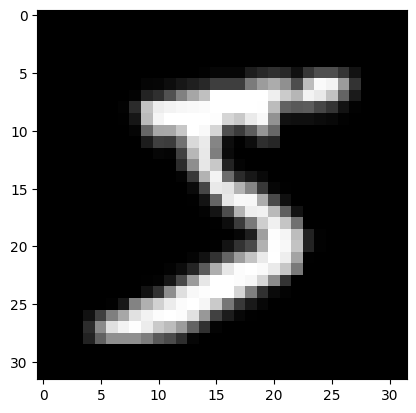

In [18]:
plt.imshow(train_dataset[0][0].numpy().reshape(32,32), cmap='gray');

In [5]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [6]:
# Модифицированная архитектура LeNet
class ModifiedLeNet(nn.Module):
    def __init__(self):
        super(ModifiedLeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding=0) # Первый сверточный
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv3 = nn.Conv2d(20, 120, kernel_size=5)
        self.fc1 = nn.Linear(120, 84) # Первый полносвязный
        self.fc2 = nn.Linear(84, 10)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout слой

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)  # Слой MaxPooling
        x = self.dropout(x)
        
        x = self.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout(x)
        
        x = self.relu(self.conv3(x))
        x = x.view(-1, 120)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ModifiedLeNet().to(device)

In [9]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [10]:
# Функция оценки точности
def evaluate_accuracy(data_loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    return correct / total

# Функция обучения модели
def train(model, train_loader, test_loader, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_accuracy = evaluate_accuracy(train_loader, model)
        test_accuracy = evaluate_accuracy(test_loader, model)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

In [11]:
train(model, train_loader, test_loader, optimizer, num_epochs)

Epoch [1/15], Loss: 0.6801, Train Accuracy: 0.9482, Test Accuracy: 0.9509
Epoch [2/15], Loss: 0.2374, Train Accuracy: 0.9675, Test Accuracy: 0.9722
Epoch [3/15], Loss: 0.1775, Train Accuracy: 0.9745, Test Accuracy: 0.9774
Epoch [4/15], Loss: 0.1497, Train Accuracy: 0.9780, Test Accuracy: 0.9804
Epoch [5/15], Loss: 0.1306, Train Accuracy: 0.9821, Test Accuracy: 0.9843
Epoch [6/15], Loss: 0.1190, Train Accuracy: 0.9845, Test Accuracy: 0.9868
Epoch [7/15], Loss: 0.1090, Train Accuracy: 0.9849, Test Accuracy: 0.9873
Epoch [8/15], Loss: 0.0997, Train Accuracy: 0.9869, Test Accuracy: 0.9866
Epoch [9/15], Loss: 0.0970, Train Accuracy: 0.9881, Test Accuracy: 0.9880
Epoch [10/15], Loss: 0.0906, Train Accuracy: 0.9891, Test Accuracy: 0.9884
Epoch [11/15], Loss: 0.0838, Train Accuracy: 0.9896, Test Accuracy: 0.9890
Epoch [12/15], Loss: 0.0823, Train Accuracy: 0.9906, Test Accuracy: 0.9895
Epoch [13/15], Loss: 0.0780, Train Accuracy: 0.9917, Test Accuracy: 0.9909
Epoch [14/15], Loss: 0.0777, Train

### Объяснение изменений:
1. **Увеличено количество фильтров** в первом и втором сверточных слоях.
2. **Добавлен Dropout** с вероятностью 0.5 после каждого сверточного слоя, что помогает предотвратить переобучение.
3. **Оптимизатор Adam** вместо SGD для более эффективной оптимизации.
4. **Функция активации ReLU** вместо Tanh для лучшей производительности.\

### Результат:
- Точность `0.9913`